# Sider+Offsides Multitask Classifier

In [26]:
import numpy as np
import tensorflow as tf
import deepchem as dc

In [27]:
"""
OFFSIDES dataset loader.
"""
from __future__ import division
from __future__ import unicode_literals

import os
import logging
import deepchem

logger = logging.getLogger(__name__)


def load_sider_offsides(featurizer='ECFP', split='index', reload=True, K=4):
  logger.info("About to load sider+ofssides dataset.")
  data_dir = deepchem.utils.get_data_dir()
  if reload:
    save_dir = os.path.join(data_dir, "sideroffsides/" + featurizer + "/" + str(split))

  dataset_file = os.path.join("/home/mamonteiro/source-code/Project-LEI/sider+offsides/", "sider+offsides_combined.csv.gz")


  dataset = deepchem.utils.save.load_from_disk(dataset_file)
  logger.info("Columns of dataset: %s" % str(dataset.columns.values))
  logger.info("Number of examples in dataset: %s" % str(dataset.shape[0]))
  SIDER_OFFSIDES_tasks = dataset.columns.values[1:].tolist()

  if reload:
    loaded, all_dataset, transformers = deepchem.utils.save.load_dataset_from_disk(
        save_dir)
    if loaded:
      return SIDER_OFFSIDES_tasks, all_dataset, transformers

  # Featurize OFFSIDES dataset
  logger.info("About to featurize OFFSIDES dataset.")
  if featurizer == 'ECFP':
    featurizer = deepchem.feat.CircularFingerprint(size=1024)
  elif featurizer == 'GraphConv':
    featurizer = deepchem.feat.ConvMolFeaturizer()
  elif featurizer == 'Weave':
    featurizer = deepchem.feat.WeaveFeaturizer()
  elif featurizer == 'Raw':
    featurizer = deepchem.feat.RawFeaturizer()

  logger.info("SIDER OFFSIDES tasks: %s" % str(SIDER_OFFSIDES_tasks))
  logger.info("%d tasks in total" % len(SIDER_OFFSIDES_tasks))

  loader = deepchem.data.CSVLoader(
      tasks=SIDER_OFFSIDES_tasks, smiles_field="smiles", featurizer=featurizer)
  dataset = loader.featurize(dataset_file)
  logger.info("%d datapoints in SIDER OFFSIDES dataset" % len(dataset))

  # Initialize transformers
  transformers = [
      deepchem.trans.BalancingTransformer(transform_w=True, dataset=dataset)
  ]
  logger.info("About to transform data")
  for transformer in transformers:
    dataset = transformer.transform(dataset)

  if split == None:
    return SIDER_OFFSIDES_tasks, (dataset, None, None), transformers

  splitters = {
      'index': deepchem.splits.IndexSplitter(),
      'random': deepchem.splits.RandomSplitter(),
      'scaffold': deepchem.splits.ScaffoldSplitter(),
      'task': deepchem.splits.TaskSplitter()
  }
  splitter = splitters[split]
  if split == 'task':
    fold_datasets = splitter.k_fold_split(dataset, K)
    all_dataset = fold_datasets
  else:
    train, valid, test = splitter.train_valid_test_split(dataset)
    if reload:
      deepchem.utils.save.save_dataset_to_disk(save_dir, train, valid, test,
                                               transformers)
    all_dataset = (train, valid, test)
  return SIDER_OFFSIDES_tasks, all_dataset, transformers


In [28]:
Sideroffsides_tasks, Sideroffsides_datasets, transformers = load_sider_offsides(featurizer='GraphConv',reload=True)
train_dataset, valid_dataset, test_dataset = Sideroffsides_datasets

Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.


In [29]:
featurizer = dc.feat.CircularFingerprint(size = 1352)

In [30]:
loader = dc.data.CSVLoader(tasks=Sideroffsides_tasks, 
                           smiles_field="smiles",
                           featurizer=featurizer)

In [31]:
dataset = loader.featurize('sider+offsides_combined.csv')
len(dataset)

Loading raw samples now.
shard_size: 8192
About to start loading CSV from sider+offsides_combined.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 0 took 2.518 s
TIMING: dataset construction took 2.577 s
Loading dataset from disk.


1690

In [32]:
train_dataset.y.shape

(1352, 27)

In [33]:
valid_dataset.y.shape

(169, 27)

In [34]:
test_dataset.y.shape

(169, 27)

In [35]:
splitter = dc.splits.RandomSplitter('offsides.csv')
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset)
#NOTE THE RENAMING:
valid_dataset, test_dataset = test_dataset, valid_dataset

Computing train/valid/test indices
TIMING: dataset construction took 0.072 s
Loading dataset from disk.
TIMING: dataset construction took 0.039 s
Loading dataset from disk.
TIMING: dataset construction took 0.030 s
Loading dataset from disk.


In [36]:
n_features = train_dataset.y.shape[0]
n_features

1352

In [37]:
params_dict = {"activation": ["relu"],
               "optimizer": ["Adam"],
               "momentum": [.9],
               "penalty": [0.]
              }


n_features = train_dataset.y.shape[0]
def model_builder(model_params, model_dir):
    model = dc.models.MultitaskClassifier(
    len(Sideroffsides_tasks), n_features, **model_params)
    return model

In [38]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)
optimizer = dc.hyper.HyperparamOpt(model_builder)
best_dnn, best_hyperparams, all_results = optimizer.hyperparam_search(params_dict, train_dataset, valid_dataset, [], metric)

Fitting model 1/1
hyperparameters: {'activation': 'relu', 'optimizer': 'Adam', 'momentum': 0.9, 'penalty': 0.0}
computed_metrics: [0.6064516129032258, 0.5492559523809524, 0.6077247191011236, 0.5299205236091631, 0.5906810035842294, 0.6212078651685393, 0.6238325281803543, 0.6083333333333334, 0.6071761416589003, 0.6385287910762737, 0.7245817245817247, 0.5768766958094664, 0.1369047619047619, 0.6343230823612585, 0.6471698113207547, 0.5315371762740184, 0.6526982212842931, 0.6044802867383513, 0.43647798742138366, 0.6109467455621302, 0.5877712031558185, 0.5913325804630153, 0.6613141380583242, 0.5813988095238096, 0.6351868196528391, 0.5728867623604466, 0.548230593607306]
Model 1/1, Metric mean-roc_auc_score, Validation set 0: 0.582120
	best_validation_score so far: 0.582120
computed_metrics: [0.9099437265945804, 0.8992048137271837, 0.8871263756467838, 0.9068572172945983, 0.9266688131433992, 0.8817486978596751, 0.9054233931464921, 0.9251117554669567, 0.8917527397500087, 0.9057634614539457, 0.914

In [39]:
best_dnn

MultitaskClassifier(activation_fns=None, bias_init_consts=None, dropouts=None,
                    layer_sizes=None, n_classes=2, n_features=1352, n_tasks=27,
                    weight_decay_penalty=None, weight_decay_penalty_type=None,
                    weight_init_stddevs=None)

In [40]:
best_hyperparams

('relu', 'Adam', 0.9, 0.0)

In [41]:
all_results

{"('relu', 'Adam', 0.9, 0.0)": 0.5821196248546592}

In [42]:
model=model_builder(params_dict,params_dict)

In [43]:
model.fit(train_dataset, nb_epoch=100)

227.32129157392163

In [44]:
obj=best_dnn.fit(train_dataset,**params_dict,epochs=100)

In [45]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)

In [46]:
train_scores = model.evaluate(train_dataset, [metric], transformers)

computed_metrics: [0.9994289830627592, 0.999482927391029, 0.999541998266488, 0.9993039542398519, 0.9981058793157961, 0.9995623057731868, 0.9996129148412651, 0.9995244999050726, 0.999530245206167, 0.9997432499011165, 0.9986058986917712, 0.999067007196666, 0.9992579139570762, 0.999464967796278, 0.9999615670398934, 0.9998955548128342, 0.9994711925866236, 0.9989248643094797, 0.9994102359056377, 0.9994955100393502, 0.9994365703136132, 0.9996963310221663, 0.9993210227272727, 0.9994188676618994, 0.9993720109853687, 0.999297529455935, 0.999449579509446]


In [47]:
valid_scores = model.evaluate(valid_dataset, [metric], transformers)

computed_metrics: [0.5383512544802868, 0.5177083333333333, 0.556320224719101, 0.5348293595137915, 0.6047491039426522, 0.5787921348314606, 0.5794283413848631, 0.5832638888888888, 0.5709847778813296, 0.5679077479650286, 0.6853281853281854, 0.5550572806753089, 0.48809523809523814, 0.6134676564156946, 0.719496855345912, 0.5089807852965748, 0.6055924027735906, 0.5844982078853047, 0.5465408805031446, 0.6151380670611439, 0.5635038038884193, 0.5295031055900621, 0.6223698781838316, 0.5799107142857143, 0.5819358634892615, 0.5390749601275917, 0.4853025114155251]


In [48]:
test_scores = model.evaluate(test_dataset, [metric], transformers)

computed_metrics: [0.45886850152905195, 0.5213203463203464, 0.4920100925147183, 0.49408284023668636, 0.5258467023172906, 0.5419520547945205, 0.576421248835042, 0.5895278167367929, 0.5440476190476191, 0.5824111822947001, 0.5949367088607596, 0.5228070175438597, 0.0892857142857143, 0.5870748299319728, 0.4138888888888889, 0.45721173161912415, 0.6029761904761906, 0.5839793281653747, 0.5110294117647058, 0.5483091787439613, 0.492430613961312, 0.4843005326604991, 0.6406423034330011, 0.5321061643835616, 0.5661016949152543, 0.5193236714975845, 0.5012605042016807]


In [49]:
print(train_scores)
print(valid_scores)
print(test_scores)

{'mean-roc_auc_score': 0.9993845771079276}
{'mean-roc_auc_score': 0.5724493171593051}
{'mean-roc_auc_score': 0.5175612181466746}


[(0.0, 0.5434392790540082)]

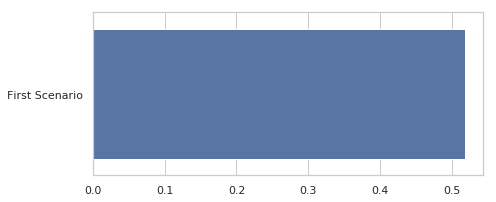

In [51]:
import seaborn as sns


sns.set(rc={'figure.figsize':(7,3)})

sns.set(style="whitegrid")
ax = sns.barplot(x=test_scores['mean-roc_auc_score'],
                    y=['First Scenario'])
                    
ax.set(xlim=(0.0, None))